# Team 7 - Milestone 1 - Data Preperation



## Dataset 

For our team project, we have chosen to analyze the <a href="https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page">NYC Yellow Taxi Dataset January (2021)</a>, which contains collected data of taxi trips in New York City. The dataset offers information such as pickup and drop-off times, trip distances, fares, passenger counts, and various surcharges. In the following, we will point out, which features we are going to include and which target we are going to predict.


## Features and Predicition

For now, we will keep most of the given features from the main dataset, but over the course of the project, we may remove additional features that are not useful to us. <br>

There are many possible predictions we could make, but we have identified the following as the most interesting and relevant for our purposes:

* Predict the `tip_amount` based on `DOLocationID`, `PULocationID`, `trip_time_minutes`, and `passenger_count`.
* Predict the `trip_distance` based on time and location data.
* Predict the `passenger_count` based on location and time
* Analyze demand patterns based on time, location, and weather conditions

While the last two points may seem similar, they are in fact distinct in focus and purpose. The prediction of passenger count focuses on a specific feature of individual trips, whereas demand refers to the general volume of trips within a certain time and location context.



## *Imports*

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

## *Clean-up of the Weather Data-Set*

In [2]:
weather = pd.read_csv('NYC_Weather_2016_2022.csv')

In our <a href="https://www.kaggle.com/datasets/aadimator/nyc-weather-2016-to-2022?resource=download">NYC weather dataset</a>, we initially filtered out all data that does not pertain to January 2021, since our primary dataset is also focused exclusively on that month.

Also we dropped some columns because of their limited relevance for our predictive tasks:

* `cloudcover (%)`
* `cloudcover_low (%)`
* `cloudcover_mid (%)`
* `cloudcover_high (%)`
* `winddirection_10m (°)`

All of the cloud cover levels do only have minimal impact on taxi demand or passenger behavior. Since it tends to correlate with other more impactful weather features such as precipitation and temperature, it does not provide significant added value for our models. <br>
`winddirection`also wont influence the taxi patterns in a meaningful way within an urban environtment like NYC.



In [3]:
weather = weather.loc[weather['time'].str[:7] == "2021-01"]
weather['time'] = pd.to_datetime(weather['time'])
columns_to_drop = [
    'cloudcover (%)',
    'cloudcover_low (%)',
    'cloudcover_mid (%)',
    'cloudcover_high (%)',
    'winddirection_10m (°)'
]
weather = weather.drop(columns=columns_to_drop)

weather

,time,temperature_2m (°C),precipitation (mm),rain (mm),windspeed_10m (km/h)
43848,2021-01-01 00:00:00,4.3,0.0,0.0,9.9
43849,2021-01-01 01:00:00,3.9,0.0,0.0,9.0
43850,2021-01-01 02:00:00,3.3,0.0,0.0,8.9
43851,2021-01-01 03:00:00,1.4,0.0,0.0,7.8
43852,2021-01-01 04:00:00,0.8,0.0,0.0,9.2
...,...,...,...,...,...
44587,2021-01-31 19:00:00,-4.4,0.0,0.0,6.2
44588,2021-01-31 20:00:00,-3.9,0.0,0.0,7.6
44589,2021-01-31 21:00:00,-4.0,0.0,0.0,9.4
44590,2021-01-31 22:00:00,-4.3,0.0,0.0,9.4


## *Clean-up of the Yellow Taxi Data-Set* <br>

As a first step, we loaded the Yellow Taxi dataset into the variable `TripData` to make it available for further processing


In [4]:
TripData = pd.read_parquet('yellow_tripdata_2021-01.parquet', engine='pyarrow')
TripData

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.00,0.5,0.00,0.00,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.50,0.5,8.65,0.00,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.50,0.5,6.05,0.00,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.50,0.5,4.06,0.00,0.3,24.36,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369764,2,2021-01-31 23:03:00,2021-01-31 23:33:00,NaN,8.89,NaN,None,229,181,0,27.78,0.00,0.5,7.46,0.00,0.3,38.54,NaN,NaN
1369765,2,2021-01-31 23:29:00,2021-01-31 23:51:00,NaN,7.43,NaN,None,41,70,0,32.58,0.00,0.5,0.00,6.12,0.3,39.50,NaN,NaN
1369766,2,2021-01-31 23:25:00,2021-01-31 23:38:00,NaN,6.26,NaN,None,74,137,0,16.85,0.00,0.5,3.90,0.00,0.3,24.05,NaN,NaN
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,NaN,19.70,NaN,None,265,188,0,53.68,0.00,0.5,0.00,0.00,0.3,54.48,NaN,NaN


In [5]:
# just for overview, delete later
missing_data = TripData.isnull().sum()
print(missing_data)

count_unknown_ratecodes = TripData[TripData['RatecodeID'] == 99].shape[0]
print(f"Number of trips with RatecodeID 99: {count_unknown_ratecodes}")

# just for overview, delete later

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            98352
trip_distance                  0
RatecodeID                 98352
store_and_fwd_flag         98352
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge       98352
airport_fee              1369764
dtype: int64
Number of trips with RatecodeID 99: 36


#### The following rows have been removed: <br>
 * Any Line cointaining 'NaN'
 * RatecodeID = 99 (Null/Unknown)
 * Payment Type = 6 (Voided trip) <br>
 
The columns `passenger_count`, `RatecodeID`, `congestion_surcharge`, and `Airport_fee` all had approximately 500,000 missing values. We deleted the corresponding rows, since the overall DataFrame is still large enough to ensure statistically meaningful analysis.

Furthermore, we excluded all rows with `RatecodeID` equal to 99 (around 42,000 entries), since they denote unknown or undefined fare types and therefore offer no analytical value.

Lastly, we removed all rows where the `payment_type` was 6, as these correspond to voided trips, which cannot be analyzed. <br>
 
 
#### The following columns have been removed: <br>
 * store_and_fwd_flag
 * airport_fee
 <br>
 
The `store_and_fwd_flag column` indicates whether the trip record was temporarily stored in the vehicle's memory before being sent to the vendor, also known as "store and forward," due to the vehicle's lack of server connectivity at the time of the trip. Since this information does not contribute to our analysis, we decided to exclude this column. <br>
The `airport_fee` column was empty, so we dropped it.

<br>

For further information, please refer to the <a href="https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf">Yellow Taxi Data Dictonary</a>

In [6]:
TripData = TripData.drop(columns=['store_and_fwd_flag'])
TripData = TripData.drop(columns=['airport_fee'])
TripData = TripData.dropna()
TripData = TripData[(TripData['RatecodeID'] != 99) & (TripData['payment_type'] != 6)]
TripData

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,142,43,2,8.0,3.0,0.5,0.00,0.00,0.3,11.80,2.5
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,238,151,2,3.0,0.5,0.5,0.00,0.00,0.3,4.30,0.0
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,132,165,1,42.0,0.5,0.5,8.65,0.00,0.3,51.95,0.0
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,138,132,1,29.0,0.5,0.5,6.05,0.00,0.3,36.35,0.0
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,68,33,1,16.5,0.5,0.5,4.06,0.00,0.3,24.36,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271412,2,2021-01-31 23:58:47,2021-02-01 00:04:40,3.0,0.81,1.0,41,74,2,5.0,0.5,0.5,0.00,0.00,0.3,6.30,0.0
1271413,2,2021-01-31 23:07:54,2021-01-31 23:19:42,1.0,3.81,1.0,113,141,2,12.5,0.5,0.5,0.00,0.00,0.3,16.30,2.5
1271414,2,2021-01-31 23:30:45,2021-01-31 23:35:13,1.0,1.32,1.0,233,237,2,6.0,0.5,0.5,0.00,0.00,0.3,9.80,2.5
1271415,2,2021-01-31 23:09:52,2021-01-31 23:51:56,2.0,10.56,1.0,56,68,1,37.5,0.5,0.5,0.00,6.12,0.3,44.92,0.0


In [7]:
print(TripData.columns)
# just for overview, delete later

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge'],
      dtype='object')


Since one of our future prediction tasks requires the duration of the trip, we have added a new column, `trip_time_minutes`, by subtracting the `tpep_pickup_datetime` from the `tpep_dropoff_datetime`. We also resorted the dataset so that the trip duration appears after the pickup and drop-off columns

In [8]:

# Calculate the trip time in minutes
TripData['trip_time_minutes'] = (TripData['tpep_dropoff_datetime'] - TripData['tpep_pickup_datetime']).dt.total_seconds() / 60

# Resorting the dataset and insert trip time behind pu/do 
col = TripData.pop('trip_time_minutes')
TripData.insert(3, 'trip_time_minutes', col)

In [9]:
TripData

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_time_minutes,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,6.033333,1.0,2.10,1.0,142,43,2,8.0,3.0,0.5,0.00,0.00,0.3,11.80,2.5
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,0.983333,1.0,0.20,1.0,238,151,2,3.0,0.5,0.5,0.00,0.00,0.3,4.30,0.0
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,27.600000,1.0,14.70,1.0,132,165,1,42.0,0.5,0.5,8.65,0.00,0.3,51.95,0.0
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,15.216667,0.0,10.60,1.0,138,132,1,29.0,0.5,0.5,6.05,0.00,0.3,36.35,0.0
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,16.533333,1.0,4.94,1.0,68,33,1,16.5,0.5,0.5,4.06,0.00,0.3,24.36,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271412,2,2021-01-31 23:58:47,2021-02-01 00:04:40,5.883333,3.0,0.81,1.0,41,74,2,5.0,0.5,0.5,0.00,0.00,0.3,6.30,0.0
1271413,2,2021-01-31 23:07:54,2021-01-31 23:19:42,11.800000,1.0,3.81,1.0,113,141,2,12.5,0.5,0.5,0.00,0.00,0.3,16.30,2.5
1271414,2,2021-01-31 23:30:45,2021-01-31 23:35:13,4.466667,1.0,1.32,1.0,233,237,2,6.0,0.5,0.5,0.00,0.00,0.3,9.80,2.5
1271415,2,2021-01-31 23:09:52,2021-01-31 23:51:56,42.066667,2.0,10.56,1.0,56,68,1,37.5,0.5,0.5,0.00,6.12,0.3,44.92,0.0


## *Clean-up of the Taxi-Zones*

In [10]:
zones = gpd.read_file("NYC Taxi Zones.geojson")

To analyse common pick up and drop off locations in the future, we have also added the `NYC Taxi Zones` Dataset. We dropped `shape_area`, `objectid` and `shape_leng` since we dont need this information in the future.

In [11]:
zones = zones[['location_id', 'zone', 'borough', 'geometry']].copy()
zones

,location_id,zone,borough,geometry
0,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."
...,...,...,...,...
258,256,Williamsburg (South Side),Brooklyn,"MULTIPOLYGON (((-73.95834 40.71331, -73.95681 ..."
259,259,Woodlawn/Wakefield,Bronx,"MULTIPOLYGON (((-73.85107 40.91037, -73.85207 ..."
260,260,Woodside,Queens,"MULTIPOLYGON (((-73.90175 40.76078, -73.90147 ..."
261,261,World Trade Center,Manhattan,"MULTIPOLYGON (((-74.01333 40.70503, -74.01327 ..."


## *Merge of zones and trips*

To analyse demand in certain areas later, we will merge `zones`  with the `TripData` <br>


Since we dont need most of the columns from our `TripData` Dataset, we only included a few. Also we renamed certain columns for clarity. 


In [12]:
zones = zones.rename(columns={'location_id': 'LocationID'})

zones['LocationID'] = zones['LocationID'].astype(int)           ## The PU/DOLocations where int64, while 
TripData['PULocationID'] = TripData['PULocationID'].astype(int) ## LocationID had the type object
TripData['DOLocationID'] = TripData['DOLocationID'].astype(int) ## so change both to int64

TripData_zones = TripData.merge(                                ## merge pickup
    zones[['LocationID', 'zone', 'borough', 'geometry']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left',
    suffixes=('', '_pickup')
)

TripData_zones = TripData_zones.merge(                          ## merge dropoff
    zones[['LocationID', 'zone', 'borough', 'geometry']],
    left_on='DOLocationID',
    right_on='LocationID',
    how='left',
    suffixes=('', '_dropoff')
)

In [13]:
TripZones = TripData_zones.rename(columns={               ## rename
    'zone': 'pickup_zone',
    'borough': 'pickup_borough',
    'geometry': 'pickup_geometry',
    'geometry_dropoff': 'dropoff_geometry'
})

TripZones = TripZones[[                              ## resort + drop certain columns
    'passenger_count',
    'tpep_pickup_datetime',
    'pickup_zone',
    'pickup_borough',
    'pickup_geometry',
    'tpep_dropoff_datetime',
    'zone_dropoff',
    'borough_dropoff',
    'dropoff_geometry'
]]

TripZones

,passenger_count,tpep_pickup_datetime,pickup_zone,pickup_borough,pickup_geometry,tpep_dropoff_datetime,zone_dropoff,borough_dropoff,dropoff_geometry
0,1.0,2021-01-01 00:30:10,Lincoln Square East,Manhattan,"MULTIPOLYGON (((-73.98148 40.76773, -73.98155 ...",2021-01-01 00:36:12,Central Park,Manhattan,"MULTIPOLYGON (((-73.97255 40.76490, -73.97301 ..."
1,1.0,2021-01-01 00:51:20,Upper West Side North,Manhattan,"MULTIPOLYGON (((-73.96884 40.78597, -73.96934 ...",2021-01-01 00:52:19,Manhattan Valley,Manhattan,"MULTIPOLYGON (((-73.96371 40.79301, -73.96418 ..."
2,1.0,2021-01-01 00:43:30,JFK Airport,Queens,"MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ...",2021-01-01 01:11:06,Midwood,Brooklyn,"MULTIPOLYGON (((-73.96015 40.62892, -73.95996 ..."
3,0.0,2021-01-01 00:15:48,LaGuardia Airport,Queens,"MULTIPOLYGON (((-73.87125 40.78604, -73.86978 ...",2021-01-01 00:31:01,JFK Airport,Queens,"MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ..."
4,1.0,2021-01-01 00:31:49,East Chelsea,Manhattan,"MULTIPOLYGON (((-74.00202 40.74044, -74.00252 ...",2021-01-01 00:48:21,Brooklyn Heights,Brooklyn,"MULTIPOLYGON (((-73.99619 40.70338, -73.99514 ..."
...,...,...,...,...,...,...,...,...,...
1271924,1.0,2021-01-31 23:07:54,Greenwich Village North,Manhattan,"MULTIPOLYGON (((-73.99136 40.72756, -73.99155 ...",2021-01-31 23:19:42,Lenox Hill West,Manhattan,"MULTIPOLYGON (((-73.96178 40.75988, -73.96197 ..."
1271925,1.0,2021-01-31 23:30:45,UN/Turtle Bay South,Manhattan,"MULTIPOLYGON (((-73.96547 40.75194, -73.96532 ...",2021-01-31 23:35:13,Upper East Side South,Manhattan,"MULTIPOLYGON (((-73.96613 40.76218, -73.96658 ..."
1271926,2.0,2021-01-31 23:09:52,Corona,Queens,"MULTIPOLYGON (((-73.85361 40.74750, -73.85325 ...",2021-01-31 23:51:56,East Chelsea,Manhattan,"MULTIPOLYGON (((-74.00202 40.74044, -74.00252 ..."
1271927,2.0,2021-01-31 23:09:52,Corona,Queens,"MULTIPOLYGON (((-73.85131 40.74984, -73.85443 ...",2021-01-31 23:51:56,East Chelsea,Manhattan,"MULTIPOLYGON (((-74.00202 40.74044, -74.00252 ..."


## *Merge of weather and trips*

In [14]:
TripData['tpep_pickup_datetime'] = TripData['tpep_pickup_datetime'].astype('datetime64[ns]')
weather['time'] = weather['time'].astype('datetime64[ns]')

TripData_sorted = TripData.sort_values('tpep_pickup_datetime')
weather_sorted = weather.sort_values('time')

TripData_weather = pd.merge_asof(
    TripData_sorted,
    weather_sorted[['time', 'temperature_2m (°C)', 'rain (mm)']],
    left_on='tpep_pickup_datetime',
    right_on='time',
    direction='backward'
)

TripData_weather = TripData_weather.dropna()
TripData_weather

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_time_minutes,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,time,temperature_2m (°C),rain (mm)
20,2,2021-01-01 00:00:04,2021-01-01 00:10:58,10.900000,1.0,2.35,1.0,48,141,2,...,0.5,0.5,0.00,0.00,0.3,14.30,2.5,2021-01-01 00:00:00,4.3,0.0
21,1,2021-01-01 00:00:18,2021-01-01 00:07:17,6.983333,2.0,0.90,1.0,170,233,2,...,3.5,0.5,0.00,0.00,0.3,10.30,2.5,2021-01-01 00:00:00,4.3,0.0
22,1,2021-01-01 00:00:28,2021-01-01 00:17:28,17.000000,1.0,4.10,1.0,95,157,2,...,0.5,0.5,0.00,0.00,0.3,17.30,0.0,2021-01-01 00:00:00,4.3,0.0
23,2,2021-01-01 00:00:29,2021-01-01 00:02:49,2.333333,1.0,0.96,1.0,79,137,2,...,0.5,0.5,0.00,0.00,0.3,8.30,2.5,2021-01-01 00:00:00,4.3,0.0
24,1,2021-01-01 00:00:36,2021-01-01 00:19:57,19.350000,1.0,9.40,1.0,138,90,2,...,3.0,0.5,0.00,6.12,0.3,37.42,2.5,2021-01-01 00:00:00,4.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271376,1,2021-01-31 23:59:49,2021-02-01 00:07:28,7.650000,1.0,1.50,1.0,75,41,1,...,0.5,0.5,0.00,0.00,0.3,8.30,0.0,2021-01-31 23:00:00,-4.5,0.0
1271377,2,2021-02-01 08:16:53,2021-02-01 08:19:38,2.750000,2.0,0.73,1.0,164,161,1,...,0.0,0.5,1.00,0.00,0.3,8.80,2.5,2021-01-31 23:00:00,-4.5,0.0
1271378,2,2021-02-01 08:23:01,2021-02-01 08:29:36,6.583333,1.0,1.39,1.0,162,141,1,...,0.0,0.5,1.54,0.00,0.3,11.84,2.5,2021-01-31 23:00:00,-4.5,0.0
1271379,2,2021-02-01 08:43:05,2021-02-01 08:54:04,10.983333,2.0,1.68,1.0,229,48,2,...,0.0,0.5,0.00,0.00,0.3,12.30,2.5,2021-01-31 23:00:00,-4.5,0.0


Number of rides according to mm of rain <br> 
Plot the Data

### Number of rides according to the temperature

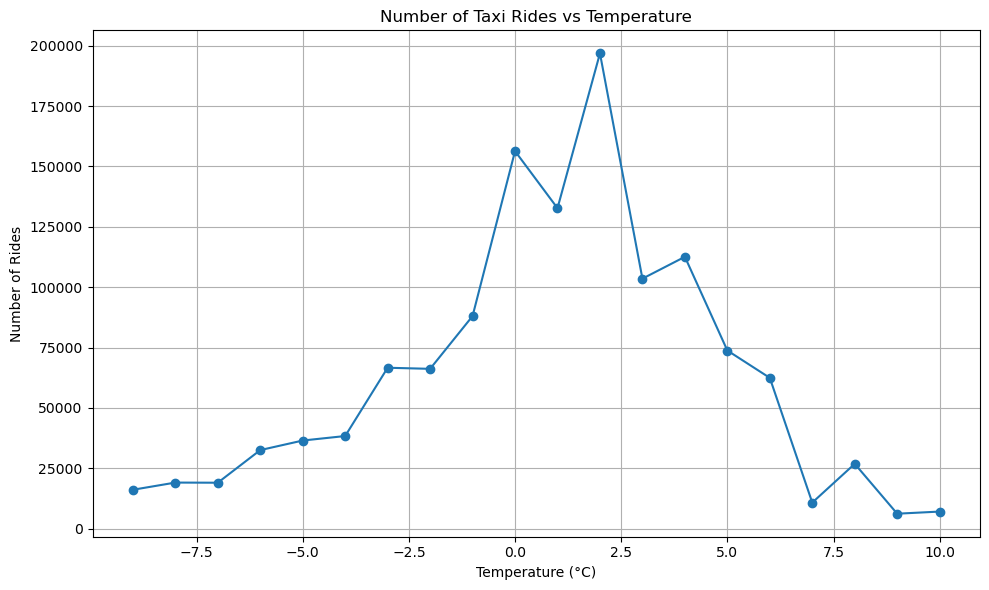

In [15]:
TripData_weather['temperature_rounded'] = TripData_weather['temperature_2m (°C)'].round()

temp_group = TripData_weather.groupby('temperature_rounded').size().reset_index(name='ride_count')

plt.figure(figsize=(10, 6))
plt.plot(temp_group['temperature_rounded'], temp_group['ride_count'], marker='o')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Rides')
plt.title('Number of Taxi Rides vs Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

The plot shows that taxi ride demand peaks around 2°C,indicating that mildly cold weather leads to the highest usage. As temperatures drop below -5°C or rise above 5°C, the number of rides decreases significantly. This suggests that in moderately cold conditions, people are more likely to use taxis to avoid discomfort, while in extreme cold or warmer weather, alternative modes of transportation may be preferred or outdoor activity decreases overall.

### Most Common Pickup-Zones



In [16]:
pickup_counts = TripZones.groupby('pickup_zone').size().reset_index(name='pickup_count')
pickup_counts = pickup_counts.sort_values(by='pickup_count', ascending=False)

print(pickup_counts.head(10))

                      pickup_zone  pickup_count
225         Upper East Side North         72588
226         Upper East Side South         71686
132               Lenox Hill West         45498
228         Upper West Side South         44489
177  Penn Station/Madison Sq West         43676
152                Midtown Center         43078
161                   Murray Hill         41840
133           Lincoln Square East         41120
153                  Midtown East         39952
131               Lenox Hill East         39875


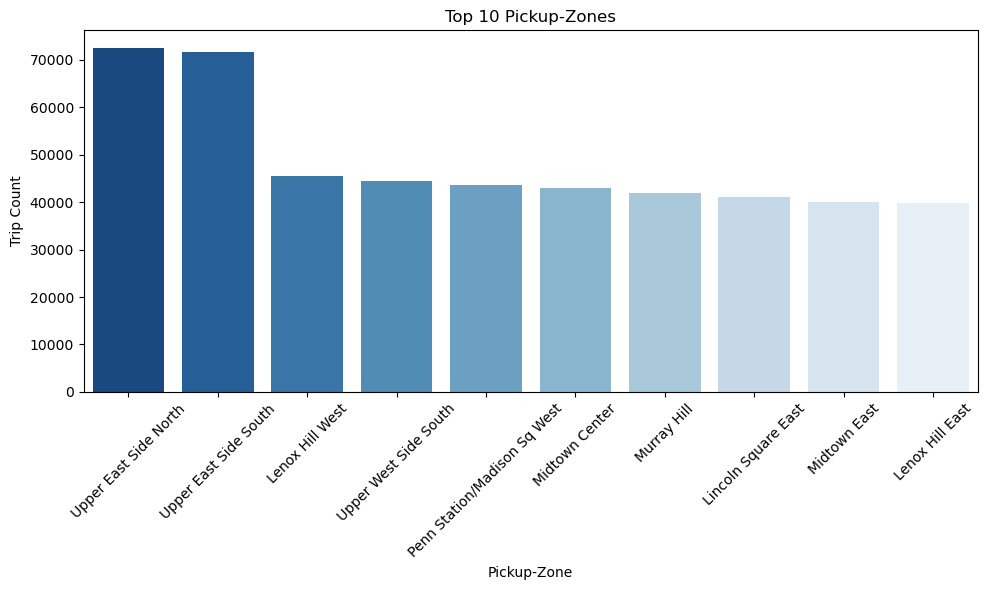

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pickup_counts.head(10),
    y='pickup_count',
    x='pickup_zone',
    hue='pickup_zone',
    palette='Blues_r',
    legend=False
)
plt.title('Top 10 Pickup-Zones')
plt.ylabel('Trip Count')
plt.xlabel('Pickup-Zone')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As we can see, Upper East Side North and Upper East Side South are cleary the most common pickup spots used by taxi customers. 

### Most Common Dropoff-Zones

In [18]:
dropoff_counts = TripZones.groupby('zone_dropoff').size().reset_index(name='dropoff_count')
dropoff_counts = dropoff_counts.sort_values(by='dropoff_count', ascending=False)

print(dropoff_counts.head(10))

              zone_dropoff  dropoff_count
229  Upper East Side North          71953
230  Upper East Side South          61331
134        Lenox Hill West          43370
232  Upper West Side South          40996
231  Upper West Side North          39753
163            Murray Hill          39030
154         Midtown Center          37721
135    Lincoln Square East          37248
133        Lenox Hill East          36151
256         Yorkville West          34262


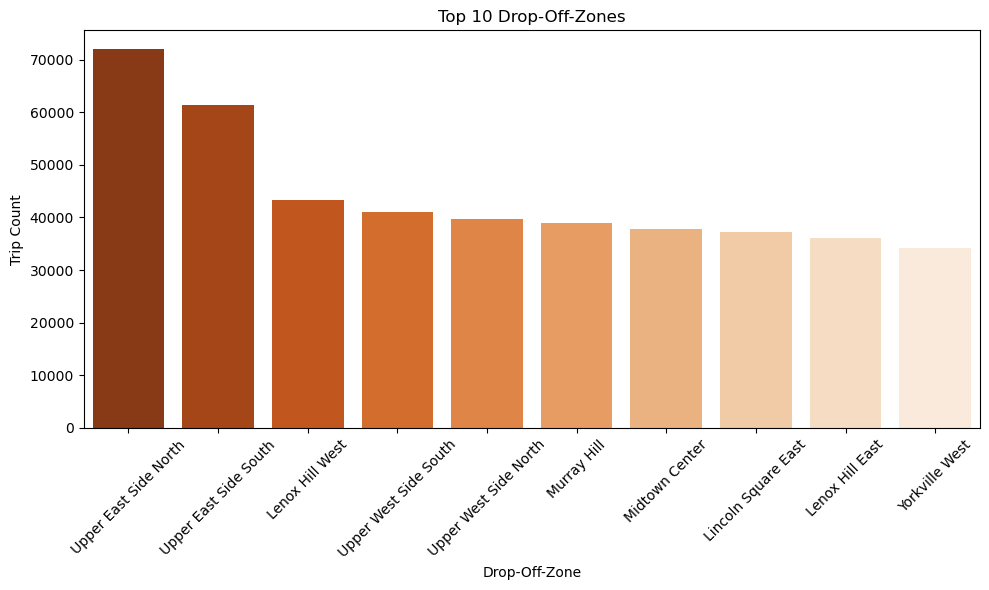

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=dropoff_counts.head(10),
    y='dropoff_count',
    x='zone_dropoff',
    hue='zone_dropoff',
    palette='Oranges_r',
    legend=False
)
plt.title('Top 10 Drop-Off-Zones')
plt.ylabel('Trip Count')
plt.xlabel('Drop-Off-Zone')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This also counts for the most common drop off spots. Upper East Side North and Upper East Side South seem to have the most demand for taxi rides in generell.

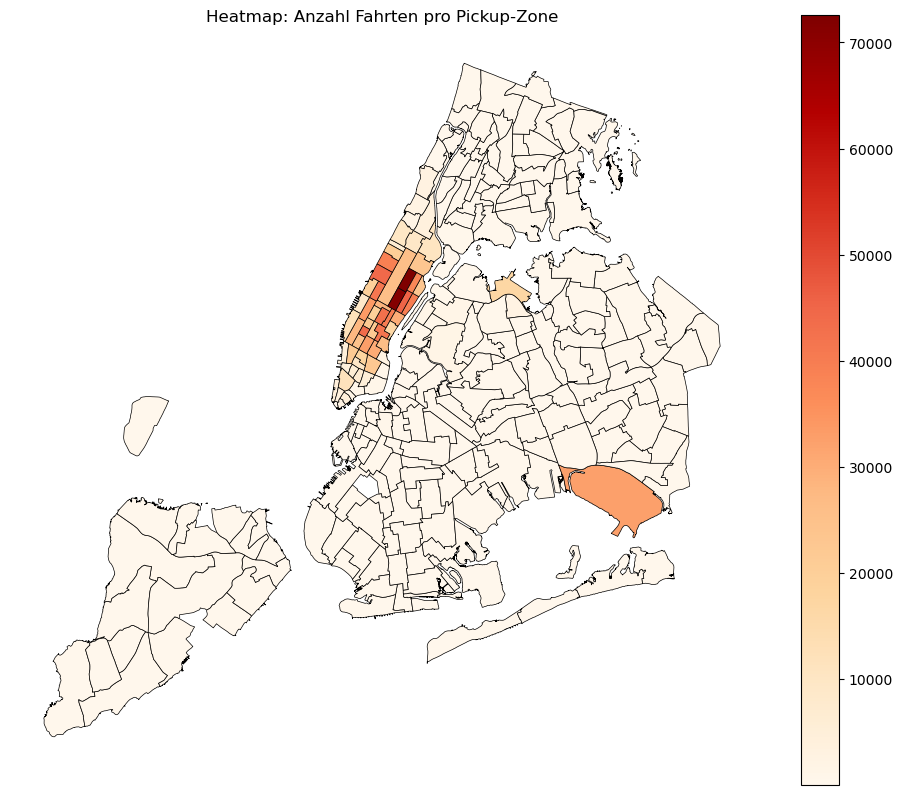

In [20]:
pickup_zone_stats = TripZones.groupby(
    ['pickup_zone', 'pickup_geometry']
).size().reset_index(name='count')

pickup_zone_stats = gpd.GeoDataFrame(pickup_zone_stats, geometry='pickup_geometry')

pickup_zone_stats.plot(
    column='count',
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    figsize=(12, 10)
)
plt.title('Heatmap: ')
plt.axis('off')
plt.show()
plt.show()

## Descriptive Analytics
* 


### First Machine Learning Model

Our first Model attempts to predict the amount of trips in a certain Area inside a 30-Minute time window given Location, time and weather. For the first model we utlise a linear Regression.

### Imports

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

### Further Data Preparation
We round the pickup timestamps down to 30-minute intervals to group trips by time slots:



### Aggregation by Time and Pickup Location
We aggregate the data to compute the average weather and trip count per 30-minute interval and pickup zone:

In [22]:
stats = TripData_weather.groupby(['tpep_pickup_datetime', 'PULocationID']).agg({
    'temperature_2m (°C)': 'mean',
    'rain (mm)': 'mean',
    'tpep_pickup_datetime': 'count'
}).rename(columns={'tpep_pickup_datetime': 'trip_count'}).reset_index()

SyntaxError: invalid syntax (286115848.py, line 1)

### Feature Engineering


In [ ]:
stats['hour'] = stats['tpep_pickup_datetime'].dt.hour
stats['weekday'] = stats['tpep_pickup_datetime'].dt.weekday

### Define input (X) and target (y) variables:


In [ ]:
```
y = stats['trip_count']
X = stats[['temperature_2m (°C)', 'rain (mm)', 'hour', 'weekday', 'PULocationID']]

### Convert pickup locations into dummy variables (one-hot encoding):

In [ ]:
X = pd.get_dummies(X, columns=['PULocationID'], drop_first=True)

### Data Scaling and Splitting

We scale the data using a standard scaler and split the Stats dataframe into 80% training set and 20% testing set.



In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

#### Model Training and Evaluation (Linear Regression)
The R2 score is 0.4424 and the MSE ist 212.6595

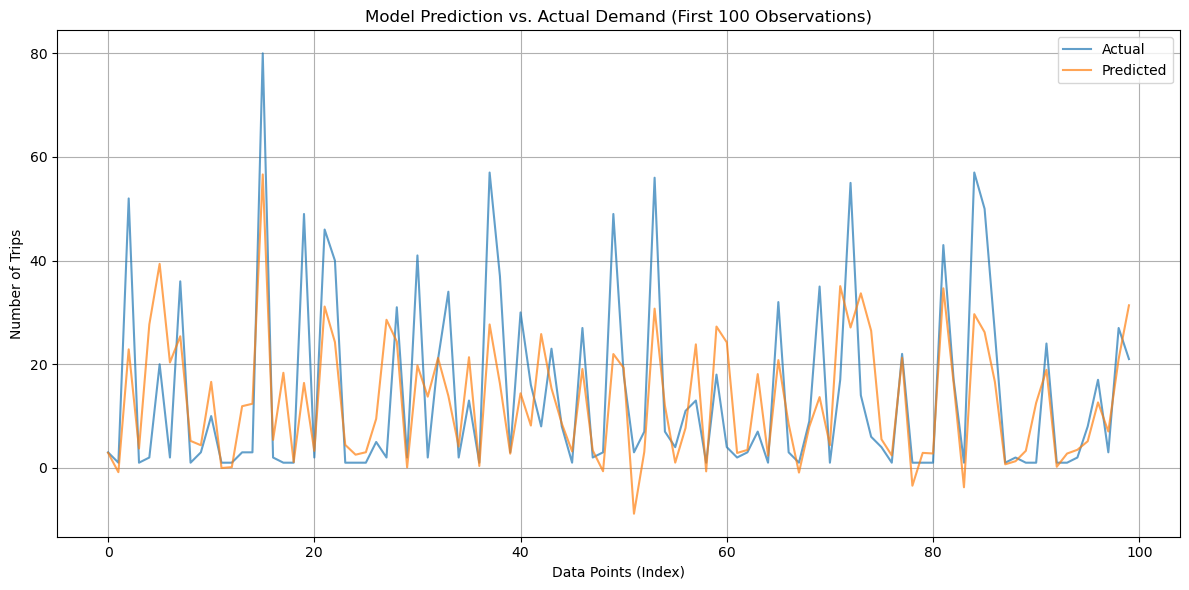